In [7]:
import import_ipynb
import hall_data
import SESnaps_data
import SE_batch_data
from astropy import units as u
from astropy import constants as const

In [2]:
hall = hall_data.get_df()
se   = SESnaps_data.df

In [140]:
df = hall.merge(se, how='outer',
               on = ['doping', 'capping', 'anneal'])

In [146]:
my_units = {
    'mu' : u.m**2/(u.V*u.s),
    'm_star' : u.M_e,
}

In [141]:
def compute_optical_mobility(df):
    omega_t = df.B2.values*u.eV/const.hbar
    omega_p = df.A2.values*u.eV/const.hbar
    eps0 = const.eps0
    e    = const.e.si
    Ne   = df.n.values *(u.m**-3)
    retval = eps0*(omega_p**2)/(Ne*e*omega_t)    
    return retval.to(my_units['mu'])

df = df.assign(mu_opt = compute_optical_mobility)    

In [152]:
def compute_effective_mass(df):
    omega_t = df.B2.values*u.eV/const.hbar
    mu_opt  = df.mu_opt.values*my_units['mu']
    e = const.e.si
    return (e/(omega_t*mu_opt)).to(my_units['m_star'])

df = df.assign(m_star = compute_effective_mass)
    

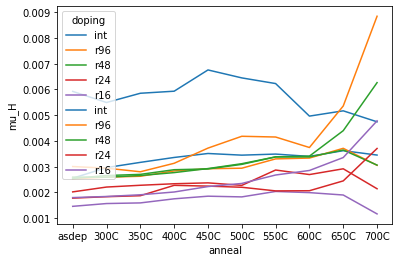

In [175]:
if __name__ == '__main__':
   # from matplotlib import pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots()
    sns.lineplot(
        x = 'anneal',
        y = 'mu_H',
        hue = 'doping',
        #style = 'anneal',
        data = df[df.capping == 'cap'],
        )
    sns.lineplot(
        x = 'anneal',
        y = 'mu_opt',
        hue = 'doping',
        #hue = 'anneal',
        data = df[df.capping == 'cap'],
    )